<a href="https://colab.research.google.com/github/j-bull2003/single_occupai/blob/main/single_photos_occupai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch==2.1.1 torchvision==0.16.1 torchaudio==2.1.1 numpy==1.26.4 ultralytics==8.0.196 --quiet


In [ ]:
from google.colab import files
import os, shutil

uploaded = files.upload()

# Make 'test' directory if it doesn't exist
os.makedirs('test', exist_ok=True)

# Move uploaded image into 'test/' and rename if needed
uploaded_filename = list(uploaded.keys())[0]
shutil.move(uploaded_filename, 'test/10.png')

In [ ]:
from ultralytics import YOLO
model = YOLO('yolov8n')

results = model.predict(source='test/10.png', conf=0.4, classes=0, save=True)



image 1/1 /content/test/10.png: 480x640 4 persons, 336.1ms
Speed: 11.6ms preprocess, 336.1ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict14


In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np

model = YOLO('yolov8n')
image_path = 'test/10.png'
results = model.predict(source=image_path, conf=0.4, classes=0, save=True)

image = cv2.imread(image_path)
bbox_centers, bbox_coords, bbox_areas = [], [], []

for result in results:
    boxes = result.boxes.xyxy.cpu().numpy()
    confidences = result.boxes.conf.cpu().numpy()
    for i, box in enumerate(boxes):
        x_min, y_min, x_max, y_max = box.astype(int)
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        center_x = (x_min + x_max) // 2
        center_y = (y_min + y_max) // 2
        area = (x_max - x_min) * (y_max - y_min)
        bbox_centers.append([center_x, center_y])
        bbox_coords.append([x_min, y_min, x_max, y_max])
        bbox_areas.append(area)

bbox_centers = np.array(bbox_centers)



image 1/1 /content/test/10.png: 480x640 4 persons, 528.1ms
Speed: 5.8ms preprocess, 528.1ms inference, 20.6ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict15


In [ ]:
from scipy.spatial import distance
import networkx as nx

G = nx.Graph()
for i in range(len(bbox_centers)):
    G.add_node(i)

for i in range(len(bbox_centers)):
    for j in range(i + 1, len(bbox_centers)):
        dist = distance.euclidean(bbox_centers[i], bbox_centers[j])
        area_ratio = min(bbox_areas[i], bbox_areas[j]) / max(bbox_areas[i], bbox_areas[j])
        if 25 <= dist <= 150 and area_ratio >= 0.5:
            G.add_edge(i, j)

group_components = [group for group in nx.connected_components(G) if len(group) > 1]

for group in group_components:
    idx = list(group)
    x_min = min(bbox_coords[i][0] for i in idx)
    y_min = min(bbox_coords[i][1] for i in idx)
    x_max = max(bbox_coords[i][2] for i in idx)
    y_max = max(bbox_coords[i][3] for i in idx)
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 3)


In [ ]:
def create_density_heatmap(bbox_centers, shape, sigma=15):
    heatmap = np.zeros((shape[0], shape[1]), dtype=np.float32)
    for x, y in bbox_centers:
        heatmap[int(y), int(x)] += 1
    heatmap = cv2.GaussianBlur(heatmap, (0, 0), sigma)
    heatmap = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    return cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

heatmap = create_density_heatmap(bbox_centers, image.shape[:2])
cv2.imwrite('group_output.jpg', image)
cv2.imwrite('density_heatmap.jpg', heatmap)


True

🧍‍♀️ People & Group Detection:


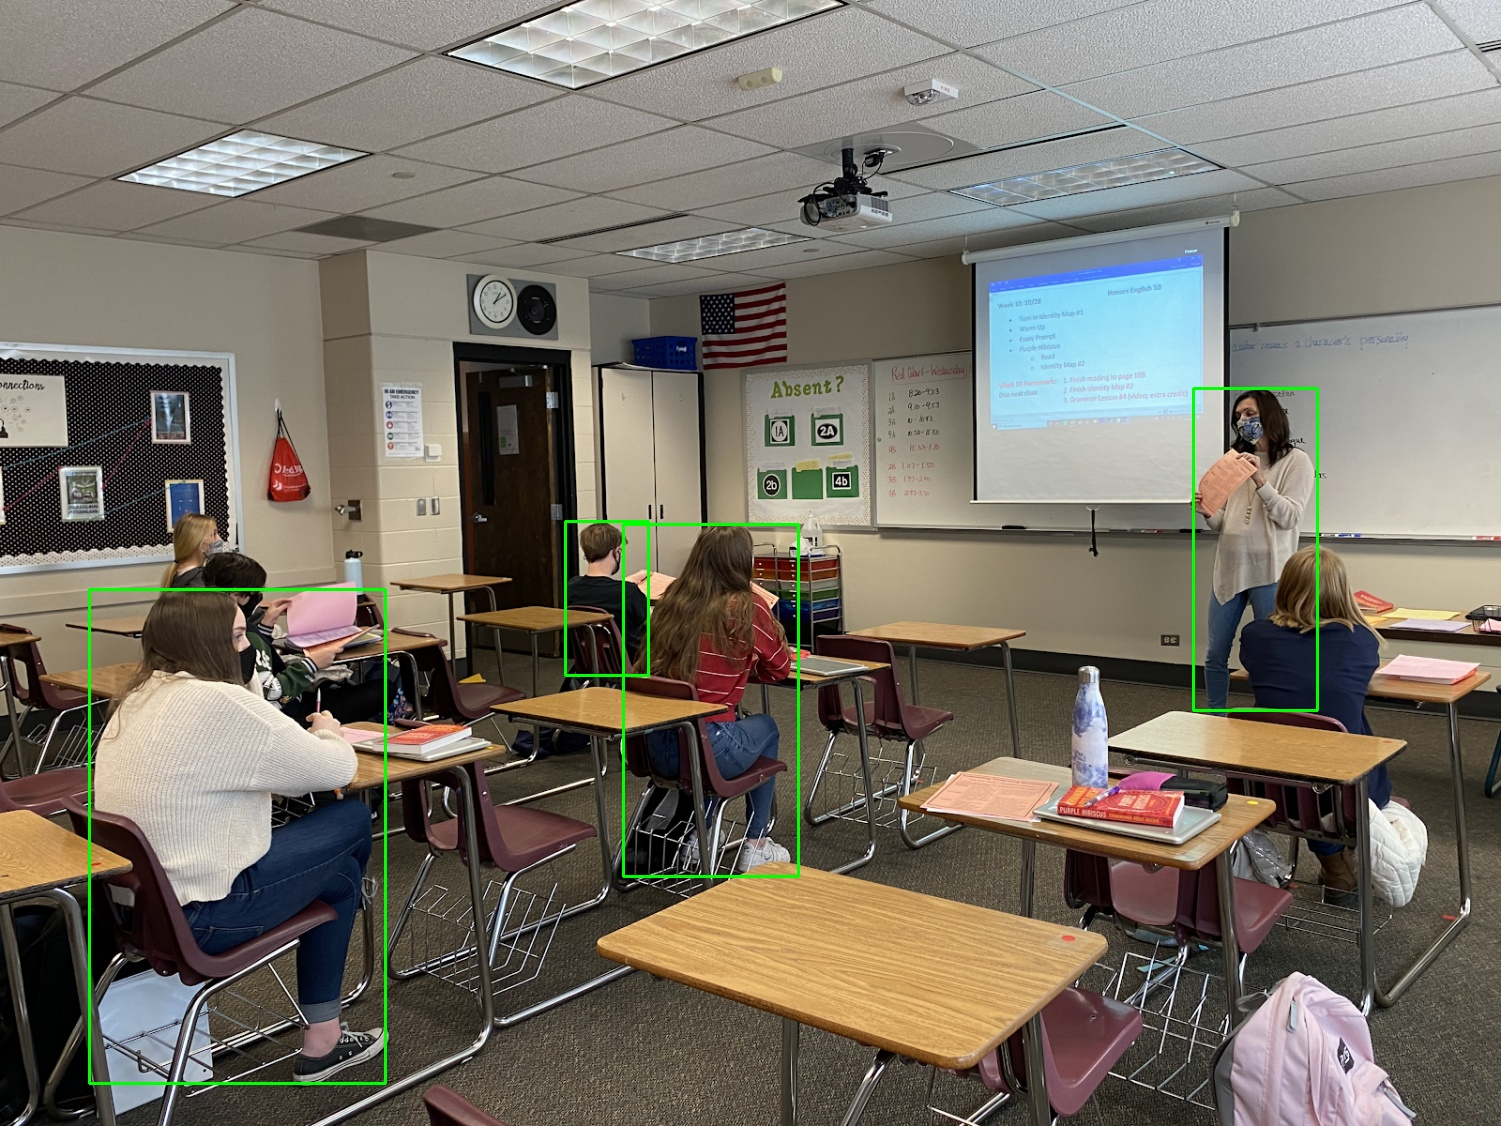

🌡️ Density Heatmap:


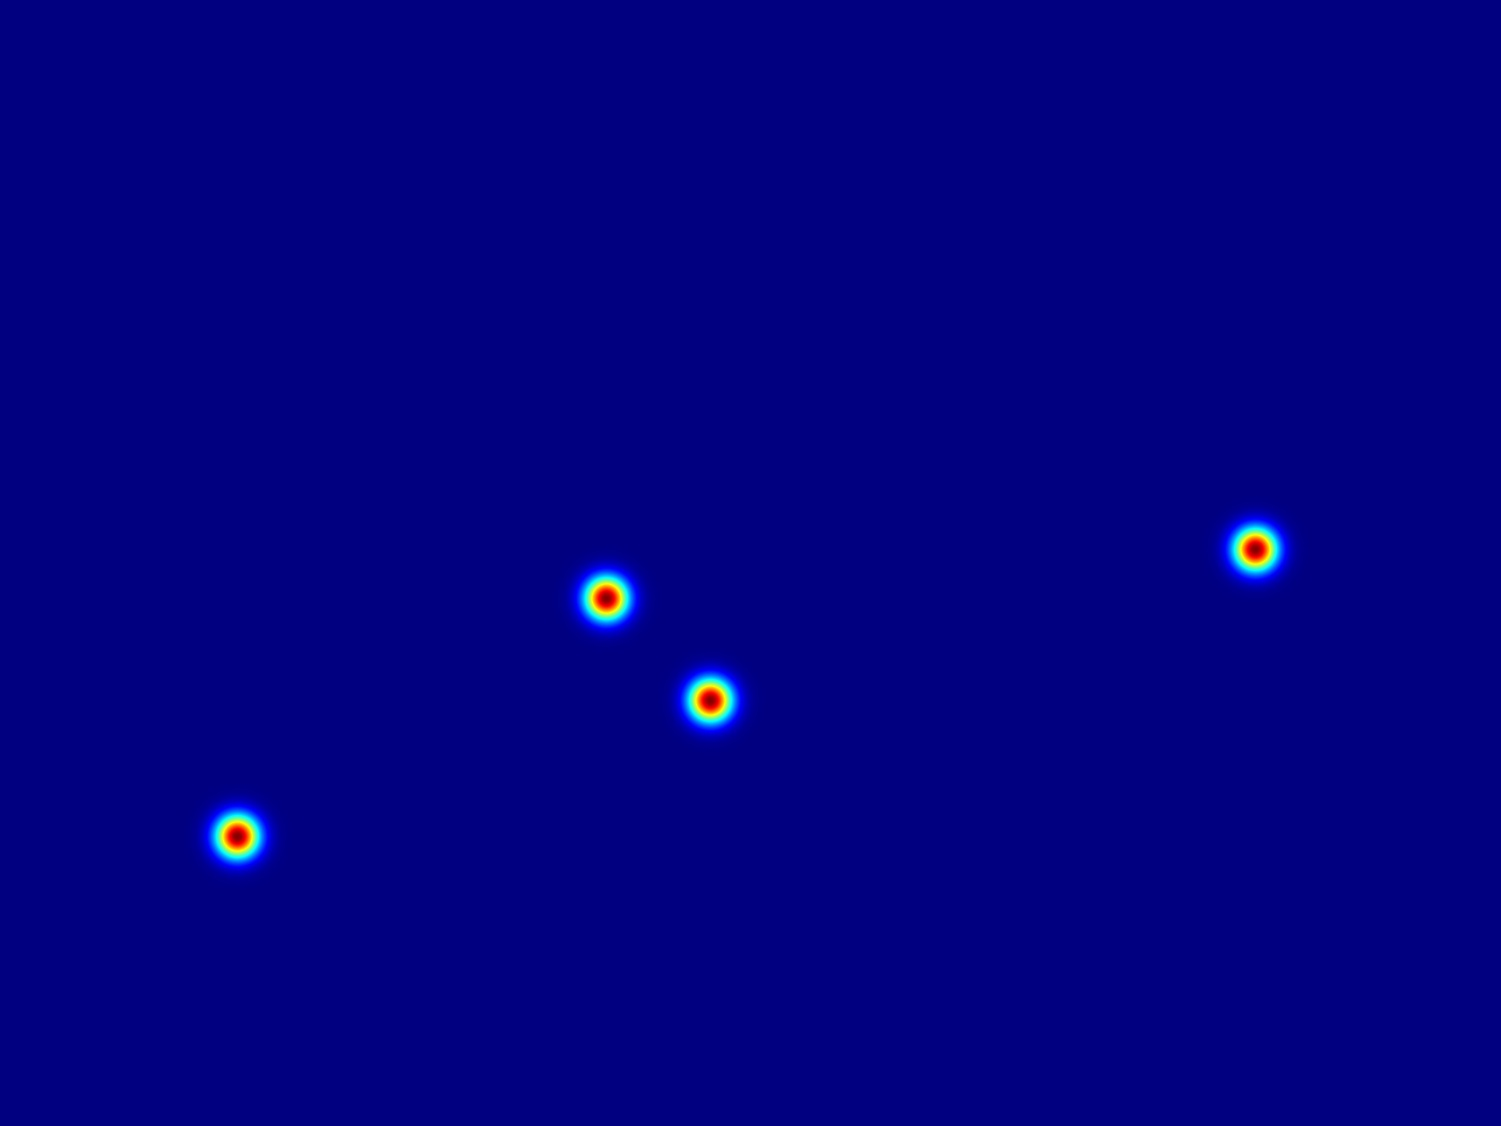

In [ ]:
from IPython.display import Image, display

print("🧍‍♀️ People & Group Detection:")
display(Image('group_output.jpg'))

print("🌡️ Density Heatmap:")
display(Image('density_heatmap.jpg'))


In [ ]:
import pandas as pd

# Rebuild the detection summary table from results
data = []

for result in results:
    boxes = result.boxes.xywh.cpu().numpy()      # Get boxes as (x_center, y_center, width, height)
    confidences = result.boxes.conf.cpu().numpy()
    class_ids = result.boxes.cls.cpu().numpy()

    for i in range(len(boxes)):
        class_id = int(class_ids[i])
        x_center, y_center, width, height = boxes[i]
        conf = float(confidences[i])
        data.append([class_id, round(x_center, 4), round(y_center, 4),
                     round(width, 4), round(height, 4), round(conf, 4)])

# Convert to DataFrame
df = pd.DataFrame(data, columns=["class_id", "x_center", "y_center", "width", "height", "confidence"])

# Show table
print("📄 YOLOv8 Detection Summary:")
display(df)


📄 YOLOv8 Detection Summary:


,class_id,x_center,y_center,width,height,confidence
0,0,237.247696,836.496704,296.450989,494.931885,0.8813
1,0,1255.740723,549.806824,123.904701,321.868195,0.6145
2,0,710.627808,700.219788,174.846405,351.922791,0.5794
3,0,607.059570,598.455811,82.924004,154.206207,0.5042
